# UK smart meter data
The UK energy regulator OFGEM requires distribution network operators (DNOs) in the UK to publish aggregated smart meter readings from their networks. We've taken that data and made it easier to use by republishing it as GeoParquet files.

This notebook gives an overview of how you can use that data, with examples of code using GeoPandas.

In [2]:
import geopandas as gpd

df = gpd.read_parquet("s3://weave.energy/smart-meter.parquet")
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 97416304 entries, 0 to 97416303
Data columns (total 8 columns):
 #   Column                           Dtype              
---  ------                           -----              
 0   dataset_id                       object             
 1   dno_alias                        object             
 2   aggregated_device_count_active   int64              
 3   total_consumption_active_import  int64              
 4   data_collection_log_timestamp    datetime64[ms, UTC]
 5   geometry                         geometry           
 6   secondary_substation_unique_id   object             
 7   lv_feeder_unique_id              object             
dtypes: datetime64[ms, UTC](1), geometry(1), int64(2), object(4)
memory usage: 5.8+ GB


We've published one month's data so far, it's not too bad to download (~700MB), but it's a bit unwieldy once you get it into a dataframe (~10GB of memory).

Let's work with some subsets to explore it further:

In [3]:
import pandas as pd
# The 7pm evening peak on 12th Feb 2024 - the first day all DNOs have data for
settlement_period = pd.Timestamp(2024, 2, 12, 19, 0, 0, tz="UTC")
df = gpd.read_parquet("s3://weave.energy/smart-meter.parquet", filters=[("data_collection_log_timestamp", "==", settlement_period)])
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 104502 entries, 0 to 104501
Data columns (total 8 columns):
 #   Column                           Non-Null Count   Dtype              
---  ------                           --------------   -----              
 0   dataset_id                       104502 non-null  object             
 1   dno_alias                        104502 non-null  object             
 2   aggregated_device_count_active   104502 non-null  int64              
 3   total_consumption_active_import  104502 non-null  int64              
 4   data_collection_log_timestamp    104502 non-null  datetime64[ms, UTC]
 5   geometry                         104502 non-null  geometry           
 6   secondary_substation_unique_id   104502 non-null  object             
 7   lv_feeder_unique_id              104502 non-null  object             
dtypes: datetime64[ms, UTC](1), geometry(1), int64(2), object(4)
memory usage: 6.4+ MB


Parquet files are great because you can load just what you need. You can even "push down" your filters to the underlying files, so you never even have to download data you don't want in the first place. Right now, we aren't partitioning our data up into different files, so for some filters you'll still have to download more than you need, but we can improve this with your help. The data is sorted by timestamp though, which should mean clients can just scan the data and only pull a subset of the rows.

Lets take a look at that data:

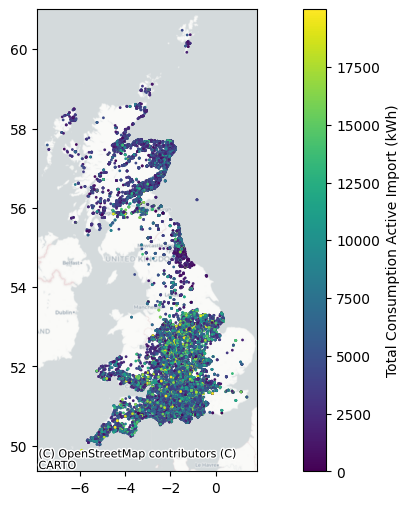

In [4]:
import contextily as cx
# There are some outliers in the data which make it hard to visualise, filter them out
df = df[df["total_consumption_active_import"] < 20000]
ax = df.plot(kind="geo", column="total_consumption_active_import", markersize=1, legend="true", figsize=(12,6), legend_kwds={"label": "Total Consumption Active Import (kWh)"})
cx.add_basemap(ax, crs=df.crs.to_string(), source=cx.providers.CartoDB.Positron)

As you can see, we don't have data for the whole country, not all UK DNOs have published it yet.

However, there's plenty there to dig into already - clearly too much to see at this kind of zoom level, even when you're just looking at a single point in time!

Next, lets slice it another way, pulling out the whole timeseries for a single substation:

In [17]:
df = gpd.read_parquet("s3://weave.energy/smart-meter.parquet", filters=[("dno_alias", "==", "NGED"), ("secondary_substation_unique_id", "==", "880536-HUCKNALL TAUPO DRIVE")])
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 6960 entries, 0 to 6959
Data columns (total 8 columns):
 #   Column                           Non-Null Count  Dtype              
---  ------                           --------------  -----              
 0   dataset_id                       6960 non-null   object             
 1   dno_alias                        6960 non-null   object             
 2   aggregated_device_count_active   6960 non-null   int64              
 3   total_consumption_active_import  6960 non-null   int64              
 4   data_collection_log_timestamp    6960 non-null   datetime64[ms, UTC]
 5   geometry                         6960 non-null   geometry           
 6   secondary_substation_unique_id   6960 non-null   object             
 7   lv_feeder_unique_id              6960 non-null   object             
dtypes: datetime64[ms, UTC](1), geometry(1), int64(2), object(4)
memory usage: 435.1+ KB


Again, this is using the ability of Parquet files and GeoPandas to just find the rows which match our filters. This is a bit slower than the previous example because the matching rows are more spread out through the file, since it's primarily sorted by time. We sort it secondarily by DNO, substation and feeder id, so we can still read contiguous blocks into memory, but we still have to download it first to find them. This is something we could change with partitioning, if this kind of query turns out to be important our users (do let us know!).

Another way we could have done this kind of query is with a bounding box. The file is a GeoParquet file and we've saved it using the latest version of the specification, meaning there is extra information in the geometry column that allows us to perform geospatial filtering as well:

In [20]:
# The substation is at -1.2326, 53.0277 so we make a box that's a tiny bit bigger
# the format is (minx, miny, maxx, maxy)
bbox = (-1.2327,53.0276,-1.2325,53.0278)
df = gpd.read_parquet("s3://weave.energy/smart-meter.parquet", bbox=bbox)
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 6960 entries, 0 to 6959
Data columns (total 8 columns):
 #   Column                           Non-Null Count  Dtype              
---  ------                           --------------  -----              
 0   dataset_id                       6960 non-null   object             
 1   dno_alias                        6960 non-null   object             
 2   aggregated_device_count_active   6960 non-null   int64              
 3   total_consumption_active_import  6960 non-null   int64              
 4   data_collection_log_timestamp    6960 non-null   datetime64[ms, UTC]
 5   geometry                         6960 non-null   geometry           
 6   secondary_substation_unique_id   6960 non-null   object             
 7   lv_feeder_unique_id              6960 non-null   object             
dtypes: datetime64[ms, UTC](1), geometry(1), int64(2), object(4)
memory usage: 435.1+ KB


The bounding box we've given here is the substation location because that's all we have right now in the way of geospatial information from the DNOs. We had to add this in ourselves for SSEN data (because they don't include it) so it's probably best to treat this just as an approximation at best. Adding further geopsatial information, such as the shape of the feeder or substation supply areas, is something we've already experimented with and we may add in further releases. Do let us know if you'd find that useful.

This covers some ways to query and extract the data, but to understand a bit more what it actually looks like, lets get some overall statistics:

In [18]:
df.groupby("lv_feeder_unique_id").agg({
    "lv_feeder_unique_id": ["count"], 
    "data_collection_log_timestamp": ["min", "max"], 
    "aggregated_device_count_active": ["min", "max"],
    "total_consumption_active_import": ["min", "max"]
})

lv_feeder_unique_id data_collection_log_timestamp  \
                                  count                           min   
lv_feeder_unique_id                                                     
1-1                                1392     2024-02-01 00:00:00+00:00   
2-2                                1392     2024-02-01 00:00:00+00:00   
3-3                                1392     2024-02-01 00:00:00+00:00   
4-4                                1392     2024-02-01 00:00:00+00:00   
5-5                                1392     2024-02-01 00:00:00+00:00   

                                              aggregated_device_count_active  \
                                          max                            min   
lv_feeder_unique_id                                                            
1-1                 2024-02-29 23:30:00+00:00                             42   
2-2                 2024-02-29 23:30:00+00:00                             75   
3-3                 2024-02-29 23:30:00+00:00                             59   
4-4                 2024-02-29 23:30:00+00:00                             28   
5-5                 2024-02-29 23:30:00+00:00                             48   

                        total_consumption_active_import         
                    max                             min    max  
lv_feeder_unique_id                                             
1-1                  42                            1864  15392  
2-2                  76                            4410  29527  
3-3                  60                            3714  22403  
4-4                  29                            1766  15376  
5-5                  49                            2803  20086

So we have 5 Low-Voltage feeders under this substation, which all have energy consumption data for 1392 settlement periods between 1st-29th Feb. The energy consumption recorded covers between 28 and 76 meters, depending on the feeder, and ranges from 1,766 kWh to 29,527 kWH in each half our.

Lets see how much they vary in a bit more detail:

<Axes: title={'center': 'Hourly kWh consumption for NGED secondary substation 880536-HUCKNALL TAUPO DRIVE, by LV Feeder'}, xlabel='Date', ylabel='Consumption (kWh)'>

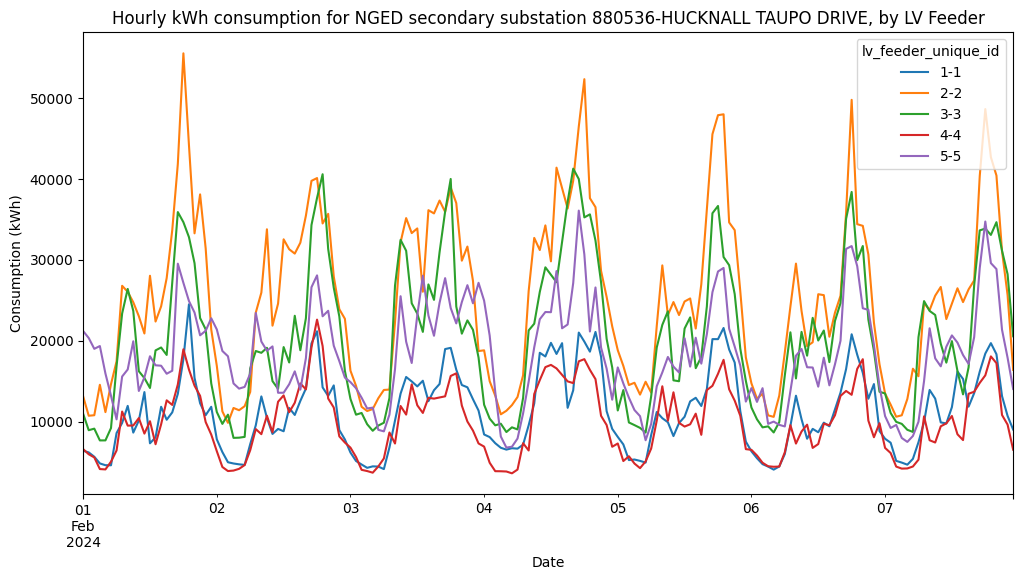

In [10]:
timeseries = df.pivot(index="data_collection_log_timestamp", columns="lv_feeder_unique_id", values="total_consumption_active_import")
timeseries["2024-02-01":"2024-02-07"].resample("h").sum().plot(figsize=(12,6), xlabel="Date", ylabel="Consumption (kWh)", title="Hourly kWh consumption for NGED secondary substation 880536-HUCKNALL TAUPO DRIVE, by LV Feeder")

It's really interesting to see how, whilst they follow some similar patterns, there's a lot of variation too! This is why we think this data is so exciting, it's a level of detail we've never had before when looking at UK energy demand.

Going back to the full dataset, we saw at the start roughly where it covers, but lets wrap up with a better idea of the coverage.

In [11]:
df = gpd.read_parquet("s3://weave.energy/smart-meter.parquet")

In [13]:
# lv_feeder ids are only unique within a secondary substation, 
# so we need to combine them with the secondary substation id to get a unique id
df["lv_feeder_dno_unique_id"] = df["secondary_substation_unique_id"] + "-" + df["lv_feeder_unique_id"]
df.groupby("dno_alias").agg({
    "secondary_substation_unique_id": ["nunique"],
    "lv_feeder_dno_unique_id": ["nunique"],
    "data_collection_log_timestamp": ["count", "min", "max"], 
    "aggregated_device_count_active": ["mean", "min", "max"],
    "total_consumption_active_import": ["min", "max"]
})

secondary_substation_unique_id lv_feeder_dno_unique_id  \
                                 nunique                 nunique   
dno_alias                                                          
NGED                                6821                   15427   
NPg                                 1463                    3632   
SSEN                               33065                   82948   
UKPN_EPN                             845                    1934   

          data_collection_log_timestamp                            \
                                  count                       min   
dno_alias                                                           
NGED                           21438054 2024-02-01 00:00:00+00:00   
NPg                             5040656 2024-02-01 00:00:00+00:00   
SSEN                           68250710 2024-02-12 00:30:00+00:00   
UKPN_EPN                        2686884 2024-02-01 00:00:00+00:00   

                                    aggregated_device_count_active           \
                                max                           mean min  max   
dno_alias                                                                     
NGED      2024-02-29 23:30:00+00:00                      31.668558   5  334   
NPg       2024-02-29 23:30:00+00:00                      22.896427   5  149   
SSEN      2024-02-29 00:00:00+00:00                      21.889166   5  611   
UKPN_EPN  2024-02-29 23:30:00+00:00                      21.596017   6  114   

          total_consumption_active_import               
                                      min          max  
dno_alias                                               
NGED                                    0  77309416634  
NPg                                     0  77309412416  
SSEN                                    0  73014451283  
UKPN_EPN                                0       105076

In [14]:
df.groupby(["dno_alias", "lv_feeder_dno_unique_id"]).agg({
    "aggregated_device_count_active": ["mean"]
}).unstack().sum(axis=1).round()

dno_alias
NGED         487906.0
NPg           82966.0
SSEN        1811186.0
UKPN_EPN      41512.0
dtype: float64

So we can see that:
- The majority of data so far comes from SSEN, who are publishing data for 1.8M meters, aggregated into 82k feeders and 33k substations
- SSEN's data only starts on the 12th of February 2024
- NGED, NPg and UKPN have data for the whole of February, with varying numbers of meters covered
- UKPN in particular are only publishing a small subset so far, with 40k meters from their EPN license area
- NGED, SSEN and NPg all have some _interesting_ max values - 77309416634 is 77 Terawatt hours of electricity usage! It looks like we will need to work with them to do a bit more data cleaning and get to the bottom of that.

There are some other nuances too:
- SSEN's timestamps suggest they're using the end of a settlement period as their `data_collection_log_timestamp` - this is standard and what we'd expect, but it's not so obviously reflected in the other data.
- UKPN seem to have interpreted the privacy-preserving cutoff for publishing data as all feeders with > 5 meters, whilst the others have gone for >=
- Looking at the map, there are some location oddities - substations off the coast, or outside of DNO license areas
- What's not reflected here is that there are also a few millions rows of bad data we've already excluded from the published data - missing values, obviously bad locations and so on. 

We'll be working with DNOs to investigate all of these issues in the future - but for now heed their warnings and use this data with some caution!